# Step 6. Validate Which File Extensions to Remove

This notebook covers step 6 in `README.md` to confirm which file extension(s) to remove from the `e3sm-diags` Git history.

What it does:
- Validates that the blob count and total file sizes match between step 3 and step 5
- Confirms which file extension(s) are causing the repo's size to be large and needs to be removed using BFG Repo-Cleaner (step 7)

Sources:
- Commit hash used: https://github.com/E3SM-Project/e3sm_diags/tree/6d4601db65443fc547825e496b5edea9636f030b
- Resolves GitHub Issue: <https://github.com/E3SM-Project/e3sm_diags/issues/306>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# File must be in same directory as notebook
df = pd.read_csv('e3sm_diags_git_files_6d4601db.csv', names=['commit_hash'])

In [3]:
df_new = pd.DataFrame()

# String parsing
df_new[['hash', 'bytes', 'file_blob']] = df['commit_hash'].str.split(n=2, expand=True)
df_new['file_extension'] = df_new.file_blob.str.rsplit('.', 1).str[-1]

# Extract mb from bytes
df_new['bytes'] = df_new['bytes'].astype(int)
df_new['mb'] = df_new['bytes'] / 1000000 

# Update order of columns
df_new = df_new[['file_blob', 'file_extension', 'bytes', 'mb']]

In [4]:
df_new

,file_blob,file_extension,bytes,mb
0,acme_diags/derivations/__init__.py,py,0,0.000000
1,e3sm_diags.egg-info/dependency_links.txt,txt,1,0.000001
2,e3sm_diags.egg-info/top_level.txt,txt,11,0.000011
3,.gitignore,gitignore,21,0.000021
4,acme_diags/__init__.py,py,22,0.000022
...,...,...,...,...
15241,tests/system/CLDMISR_ERA-Interim_ANN_198001_20...,nc,18504591,18.504591
15242,tests/climo/PRECC_200001_201412.nc,nc,24068544,24.068544
15243,tests/climo/PRECL_200001_201412.nc,nc,24068552,24.068552
15244,acme_diags/plotset5/set5_ANN_T200_ECMWF/test_l...,pdf,41618904,41.618904


## Aggregate

In [5]:
# Get the total file count by file extension
df_agg_ext_count = df_new.value_counts(subset=['file_extension']).reset_index()
df_agg_ext_count.columns = ['file_extension', 'blob_count']

# Get the total file size in mb by file extension
df_agg_ext_size = df_new.groupby('file_extension').agg({'mb': 'sum'}).reset_index()

In [6]:
df_agg_final = pd.merge(df_agg_ext_count, df_agg_ext_size, how='left', on= ['file_extension']).reset_index()
df_agg_final = df_agg_final.sort_values('file_extension')

In [7]:
# Both of these match "Step 3. Check Current Repo Size with `git-sizer`"
print(f"Total File Blobs: {df_agg_final['blob_count'].sum()}")
print(f"Total File Size (GB): {round(df_agg_final['mb'].sum()/1000, 3)} GB")
df_agg_final.sort_values('mb', ascending=False)

Total File Blobs: 15246
Total File Size (GB): 1.737 GB


,index,file_extension,blob_count,mb
0,0,nc,4024,793.739985
1,1,png,3088,768.064807
43,43,pdf,2,52.754669
4,4,doctree,882,31.174238
2,2,html,2983,29.072084
3,3,py,2109,15.951902
41,41,tar,2,9.850368
11,11,pickle,113,7.152515
5,5,json,389,5.017626
25,25,ttf,15,4.916088


## Plot

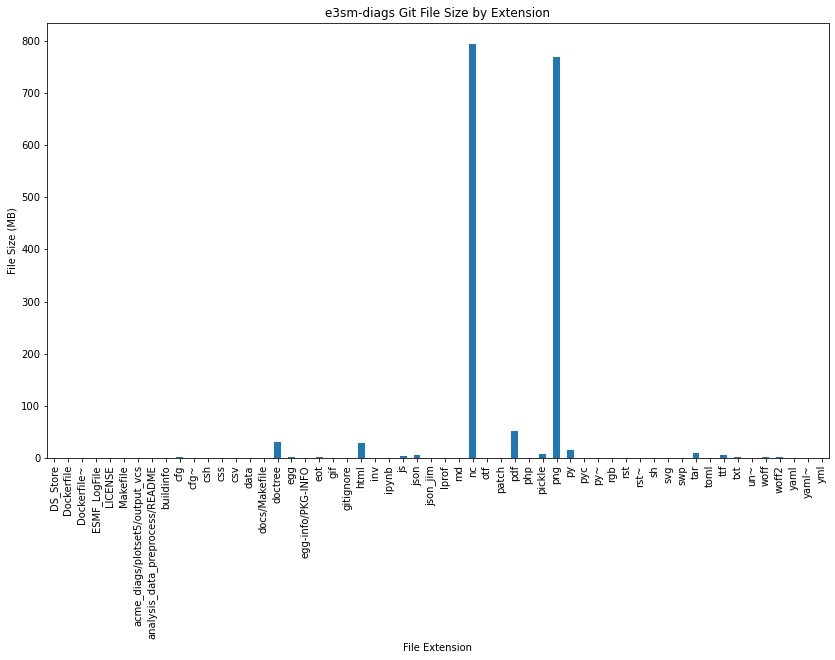

In [8]:
plot = df_agg_final.plot(x='file_extension', y='mb', kind='bar', figsize=(14, 8), title='e3sm-diags Git File Size by Extension', legend=None)
plt.ylabel('File Size (MB)')
plt.xlabel('File Extension')

plt.xticks(rotation=90)
plt.xticks(rotation=90)
plt.show()

In [9]:
df_agg_final[(df_agg_final.file_extension.isin(['nc', 'png', 'pdf', 'tar']))].sort_values('mb', ascending=False)

,index,file_extension,blob_count,mb
0,0,nc,4024,793.739985
1,1,png,3088,768.064807
43,43,pdf,2,52.754669
41,41,tar,2,9.850368


## Summary
The file extension with the largest total file sizes are `.nc`, `.png`, `.pdf`, and `.tar`.

Now we can run BFG Repo-cleaner to delete these output files in step 7.
